# Motivaciones: el zoológico de comportamientos neuronales

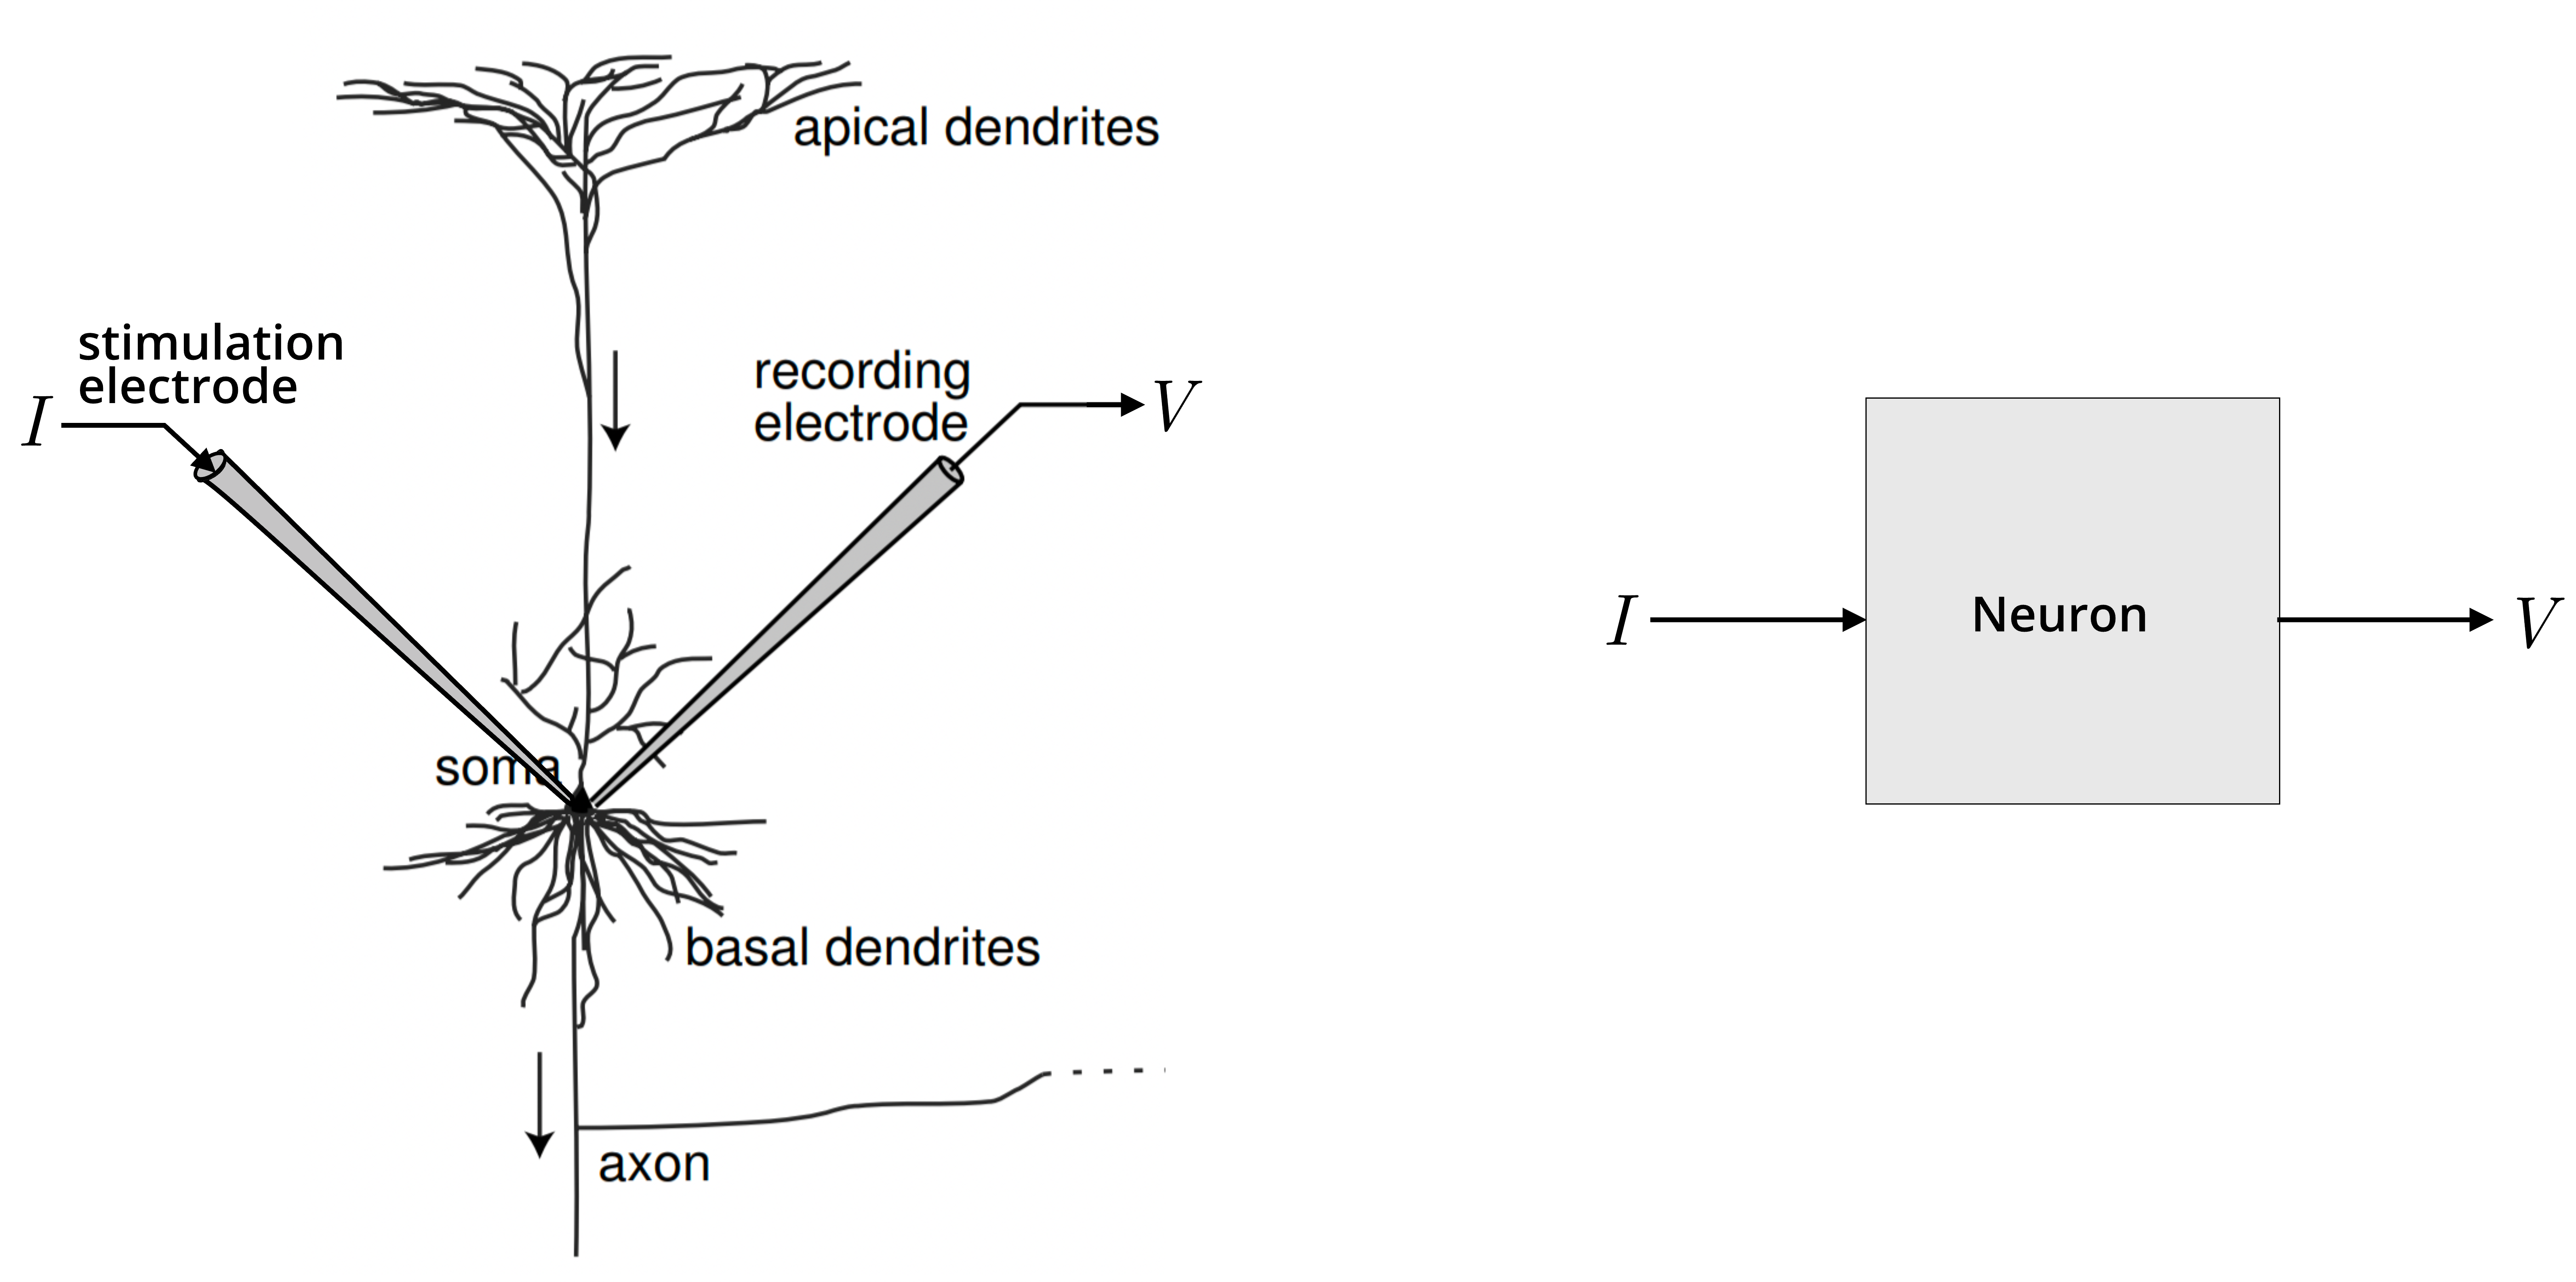

## Revisión de paquetería instalada

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.function_base import linspace

from scipy.integrate import odeint
from numpy import exp

## Plots interactivos en jupyter

In [6]:
pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [10]:
%matplotlib ipympl # Activa el widget
%matplotlib inline # Desactiva el widget

## Implementación de un modelo basado en conductancias: STG

In [7]:
# Funciones auxiliares para la construcción del campo vectorial

def xinf(x,a,b):
    return 1/(1+exp((x+a)/b))               # Estado fijo

def taux(x,a,b,d,e):
    return a-b/(1+exp((x+d)/e))             # Constantes de tiempo

In [8]:
# Corriente de sodio

### Variable de activación

def mNainf(v):
    return xinf(v,25.,-5.) 

def taumNa(v):
    return taux(v,0.75,0.5,100.,-20.)

### Variable de inactivación

def hNainf(v):
    return xinf(v,40.,10.)

def tauhNa(v):
    return taux(v,4.,3.5,50.,-20.)

# Corrientes de potasio

### Potasio retardado

def mKdinf(v):
    return xinf(v,15.,-10.)

def taumKd(v):
    return taux(v,5.,4.5,30.,-20.)

### Potasio tipo-A rápido

def mAfinf(v):
    return xinf(v,80.,-10.)

def taumAf(v):
    return taux(v,0.75,0.5,100.,-20.)

def hAfinf(v):
    return xinf(v,60.,5.)

def tauhAf(v):
    return 10*taux(v,0.75,0.5,100.,-20.)

### Potasio tipo-A lento

def mAsinf(v):
    return xinf(v,60.,-10.)

def taumAs(v):
    return 10*taux(v,0.75,0.5,100.,-20.)

def hAsinf(v):
    return xinf(v,20.,5.)

def tauhAs(v):
    return 100*taux(v,0.75,0.5,100.,-20.)

### Potasio regulado por calcio

def mKCainf(ca):
    return xinf(ca,-30.,-10.)

def taumKCa(ca):
    return 500.

# Corrientes de calcio

### Calcio tipo-L

def mCaLinf(v):
    return xinf(v,45.,-5.)

def taumCaL(v):
    return taux(v,6.,5.5,30.,-20.)

### Calcio tipo-T

def mCaTinf(v):
    return xinf(v,60.,-5.)

def taumCaT(v):
    return taux(v,6.,5.5,30.,-20.)

def hCaTinf(v):
    return xinf(v,85.,10.)

def tauhCaT(v):
    return 100*taux(v,6.,5.5,30.,-20.)

### Calcio

def tauCa(ca):
    return 500.

# Corriente activada por hiperpolarización

def mHinf(v):
    return xinf(v,85.,10.)

def taumH(v):
    return 50*taux(v,6.,5.5,30.,-20.)

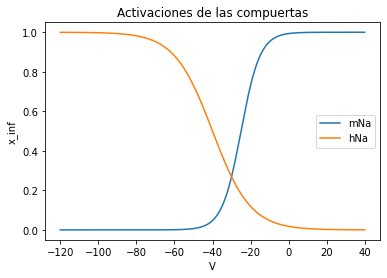

In [14]:
# Graficación de algunas de las funciones de estado fijo y constantes de tiempo

### Funciones de estado fijo de las compuertas de sodio

%matplotlib inline

Vplot = linspace(-120.,40.,10001)
p = plt.plot(Vplot,mNainf(Vplot),label="mNa")
p = plt.plot(Vplot,hNainf(Vplot),label="hNa")
p = plt.xlabel("V")
p = plt.ylabel("x_inf")
p = plt.title("Activaciones de las compuertas")
p = plt.legend()

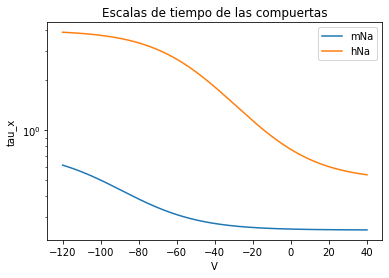

In [15]:
### Constantes de tiempo de las compuertas de sodio

p = plt.plot(Vplot,taumNa(Vplot),label="mNa")
p = plt.plot(Vplot,tauhNa(Vplot),label="hNa")
# p = plt.plot(Vplot,taumKd(Vplot),label="mKd")
# p = plt.plot(Vplot,taumAf(Vplot),label="mAf")
# p = plt.plot(Vplot,tauhAf(Vplot),label="hAf")
# p = plt.plot(Vplot,taumAs(Vplot),label="mAs")
# p = plt.plot(Vplot,tauhAs(Vplot),label="hAs")
# p = plt.plot(Vplot,taumCaL(Vplot),label="mCaL")
# p = plt.plot(Vplot,taumCaT(Vplot),label="mCaT")
# p = plt.plot(Vplot,tauhCaT(Vplot),label="hCaT")
# p = plt.plot(Vplot,taumH(Vplot),label="mH")
p = plt.xlabel("V")
p = plt.ylabel("tau_x")
p = plt.title("Escalas de tiempo de las compuertas")
p = plt.yscale("log")
p = plt.legend()

## Definición de los parámetros

In [36]:
### Tren de ráfagas

# Conductancias maximales

gL = 2.0
gNa = 100.
gKd = 65.
gAf = 0.
gAs = 0.
gKCa = 10.
gCaL = 5.
gCaT = 0.
gH = 0.

# Corrientes aplicadas en función del tiempo

### Parámetro base

Iapp = -25.

I1 = 7.
t1i = 2000.
t1f = 2010.
I2 = 4.
t2i = 5000.
t2f = 10001.

Tf = 10000.

# V0 = -70.0
# Ca0 = 3.0*(-alpha*gCaL*mCaL0*(V0-ECa)-beta*gCaT*mCaT0*hCaT0*(V0-ECa))

In [37]:
# Potenciales de reversión

ENa = 40.            # Corrientes de sodio
EK = -90.            # Corrientes de potasio
ECa = 120.           # Corrientes de calcio
EH = -40.            # Corriente activada por hiperpolarización
EL = -50.            # Corriente de fuga

C = 0.1              # Capacidad eléctrica
alpha = 0.1          # Peso de ICaL en la dinámica del calcio
beta = 0.1           # Peso de ICaT en la dinámica del calcio

In [39]:
# Aplicación en bloque de corriente

def I(t):
#     return 17*np.sin(0.1*t)
    return I1*(t1i<=t and t<=t1f)+I2*(t2i<=t and t<=t2f) 



# Función auxiliar de graficación de la corriente aplicada

def Igraph(t):
    Ivec = np.zeros(len(t))
    for k in range(len(t)):
        Ivec[k] = I(t[k])+Iapp
    return Ivec

In [40]:
# Tiempo de integración

t = linspace(0,Tf,100001)

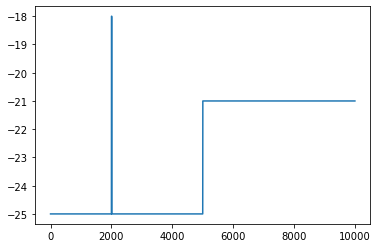

In [41]:
plt.plot(t,Igraph(t))

In [42]:
# Construcción del campo vectorial

### Corrientes iónicas del sistema

def INa(V,mNa,hNa):
    return gNa*mNa*hNa*(V-ENa)

def IKd(V,mKd):
    return gKd*mKd*(V-EK)

def IAf(V,mAf,hAf):
    return gAf*mAf*hAf*(V-EK)

def IAs(V,mAs,hAs):
    return gAs*mAs*hAs*(V-EK)

def IKCa(V,Ca):
    return gKCa*mKCainf(Ca)*(V-EK)

def ICaL(V,mCaL):
    return gCaL*mCaL*(V-ECa)

def ICaT(V,mCaT,hCaT):
    return gCaT*mCaT*hCaT*(V-ECa)

def IH(V,mH):
    return gH*mH*(V-EH)

def IL(V):
    return gL*(V-EL)

# Funciones de evolución para cada variable dinámica

def Vdyn(V,mNa,hNa,mKd,mAf,hAf,mAs,hAs,mCaL,mCaT,hCaT,mH,Ca,t):
    return 1/C*(Iapp+I(t)-INa(V,mNa,hNa)-IKd(V,mKd)-IAf(V,mAf,hAf)-IAs(V,mAs,hAs)-IKCa(V,Ca)-ICaL(V,mCaL)-ICaT(V,mCaT,hCaT)-IH(V,mH)-IL(V))

def mNadyn(V,mNa):
    return (mNainf(V)-mNa)/taumNa(V)

def hNadyn(V,hNa):
    return (hNainf(V)-hNa)/tauhNa(V)

def mKddyn(V,mKd):
    return (mKdinf(V)-mKd)/taumKd(V)

def mAfdyn(V,mAf):
    return (mAfinf(V)-mAf)/taumAf(V)

def hAfdyn(V,hAf):
    return (hAfinf(V)-hAf)/tauhAf(V)

def mAsdyn(V,mAs):
    return (mAsinf(V)-mAs)/taumAs(V)

def hAsdyn(V,hAs):
    return (hAsinf(V)-hAs)/tauhAs(V)

def mCaLdyn(V,mCaL):
    return (mCaLinf(V)-mCaL)/taumCaL(V)

def mCaTdyn(V,mCaT):
    return (mCaTinf(V)-mCaT)/taumCaT(V)

def hCaTdyn(V,hCaT):
    return (hCaTinf(V)-hCaT)/tauhCaT(V)

def mHdyn(V,mH):
    return (mHinf(V)-mH)/taumH(V)

def Cadyn(V,mCaL,mCaT,hCaT,Ca):
    return (-alpha*gCaL*mCaL*(V-ECa)-beta*gCaT*mCaT*hCaT*(V-ECa)-Ca)/tauCa(Ca)

# Campo vectorial

def CBM(u,t):
    
    V,mNa,hNa,mKd,mAf,hAf,mAs,hAs,mCaL,mCaT,hCaT,mH,Ca = u
    
    dV = Vdyn(V,mNa,hNa,mKd,mAf,hAf,mAs,hAs,mCaL,mCaT,hCaT,mH,Ca,t)
    dmNa = mNadyn(V,mNa)
    dhNa = hNadyn(V,hNa)
    dmKd = mKddyn(V,mKd)
    dmAf = mAfdyn(V,mAf)
    dhAf = hAfdyn(V,hAf)
    dmAs = mAsdyn(V,mAs)
    dhAs = hAsdyn(V,hAs)
    dmCaL = mCaLdyn(V,mCaL)
    dmCaT = mCaTdyn(V,mCaT)
    dhCaT = hCaTdyn(V,hCaT)
    dmH = mHdyn(V,mH)
    dCa = Cadyn(V,mCaL,mCaT,hCaT,Ca)
    
    du = [dV,dmNa,dhNa,dmKd,dmAf,dhAf,dmAs,dhAs,dmCaL,dmCaT,dhCaT,dmH,dCa]
    
    return du

In [43]:
# Condiciones iniciales

V0 = -70.

# Las compuertas y el calcio se toman en su estado fijo

mNa0 = mNainf(V0)
hNa0 = hNainf(V0)
mKd0 = mKdinf(V0)
mAf0 = mAfinf(V0)
hAf0 = hAfinf(V0)
mAs0 = mAsinf(V0)
hAs0 = hAsinf(V0)
mCaL0 = mCaLinf(V0)
mCaT0 = mCaTinf(V0)
hCaT0 = hCaTinf(V0)
mH0 = mHinf(V0)
Ca0 = -alpha*gCaL*mCaL0*(V0-ECa)-beta*gCaT*mCaT0*hCaT0*(V0-ECa)

u0 = [V0,mNa0,hNa0,mKd0,mAf0,hAf0,mAs0,hAs0,mCaL0,mCaT0,hCaT0,mH0,Ca0]

In [44]:
u = odeint(CBM,u0,t)

In [45]:
V = u[:,0]

Text(0, 0.5, 'I (μA)')

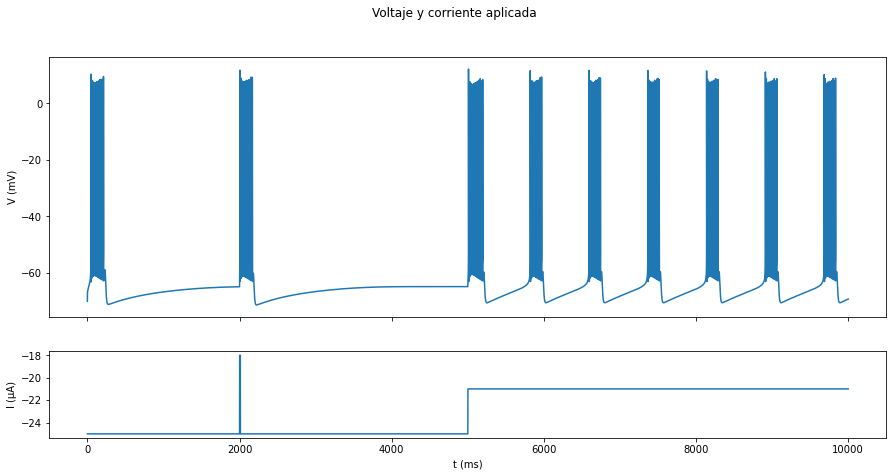

In [46]:
fig, axs= plt.subplots(2, sharex=True,gridspec_kw={'height_ratios': [3,1]},figsize=(15,7))
fig.suptitle('Voltaje y corriente aplicada')

axs[0].plot(t,V)
axs[1].plot(t,Igraph(t))
axs[1].set_xlabel('t (ms)')
axs[0].set_ylabel('V (mV)')
axs[1].set_ylabel('I (μA)')